In [1]:
# Importing the libraries
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from wordcloud import WordCloud

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd '/content/gdrive/My Drive/Colab Notebooks/Bank Reviews Complaints Analysis/'

/content/gdrive/My Drive/Colab Notebooks/Bank Reviews Complaints Analysis


#1. Reading and Processing Data

In [5]:
reviews_df = pd.read_excel("BankReviews.xlsx")
reviews_df.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [6]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      505 non-null    datetime64[ns]
 1   Stars     505 non-null    int64         
 2   Reviews   505 non-null    object        
 3   BankName  505 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [7]:
reviews_df.shape

(505, 4)

## Dropping the irrelevant variables

In [0]:
reviews_df.drop(['Date','BankName'],axis=1,inplace=True)

In [9]:
reviews_df.head()

,Stars,Reviews
0,5,"Great job, Wyndham Capital! Each person was pr..."
1,5,Matthew Richardson is professional and helpful...
2,5,We had a past experience with Wyndham Mortgage...
3,5,We have been dealing with Brad Thomka from the...
4,5,I can't express how grateful I am for the supp...


In [10]:
reviews_df.shape

(505, 2)

In [11]:
reviews_df.isnull().sum()

Stars      0
Reviews    0
dtype: int64

## Exploring Data

In [12]:
reviews_df['Stars'].value_counts()

5    410
1     95
Name: Stars, dtype: int64

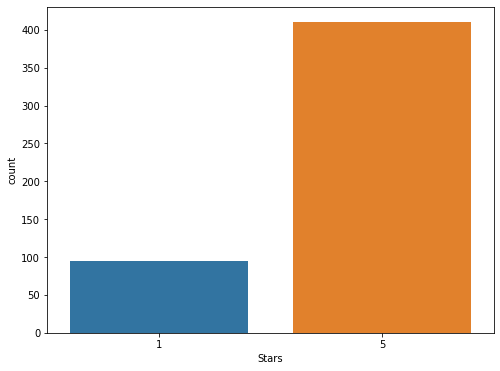

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(reviews_df.Stars)
plt.show()

## Cleaning the data

In [0]:
# Taking backup before cleaning the data for final representation
reviews_df_bkp = reviews_df[reviews_df.columns]

In [0]:
#Abbrevations and Words correction
def clean_text(text):
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'\n',' ',text)
    text = re.sub(r'\S+@\S+','',text)
    text = re.sub(r'\S+\S+@','',text)
    text = re.sub(r'^br$', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()$\#;{}+=~|!?.:`,'0-9',/]", "", text)
    return(text)

# From the above function , we have handled Newlines, Single Quotes,Digits [0-9],Converted into Lower case.

In [0]:
def decontracted(text):
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [17]:
reviews_df['Reviews']

0      Great job, Wyndham Capital! Each person was pr...
1      Matthew Richardson is professional and helpful...
2      We had a past experience with Wyndham Mortgage...
3      We have been dealing with Brad Thomka from the...
4      I can't express how grateful I am for the supp...
                             ...                        
500    \r\nI never write reviews but had to this time...
501    \r\nIt all started when Bob G ran a credit che...
502    \r\nWhat a horrible experience. We have excell...
503    \r\nRep was extremely professional, friendly, ...
504    \r\nI was working with a loan consultant from ...
Name: Reviews, Length: 505, dtype: object

In [0]:
reviews_df['Reviews'] = reviews_df['Reviews'].apply(lambda x:decontracted(x))
reviews_df['Reviews'] = reviews_df['Reviews'].apply(lambda x:clean_text(x))

In [19]:
reviews_df['Reviews']

0      great job wyndham capital each person was prof...
1      matthew richardson is professional and helpful...
2      we had a past experience with wyndham mortgage...
3      we have been dealing with brad thomka from the...
4      i can not express how grateful i am for the su...
                             ...                        
500    i never write reviews but had to this time to ...
501    it all started when bob g ran a credit check w...
502    what a horrible experience we have excellent c...
503    rep was extremely professional friendly and he...
504    i was working with a loan consultant from nasb...
Name: Reviews, Length: 505, dtype: object

## Removing Stopwords

In [0]:
stop_words = stopwords.words('english')

In [0]:
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

In [0]:
reviews_df['Reviews'] = reviews_df['Reviews'].apply(lambda x:remove_stopwords(x))

In [23]:
reviews_df['Reviews']

0      great job wyndham capital person professional ...
1      matthew richardson professional helpful helped...
2      past experience wyndham mortgage would without...
3      dealing brad thomka beginning started stressfu...
4      express grateful support zach provided family ...
                             ...                        
500    never write reviews time prevent anyone making...
501    started bob g ran credit check without knowled...
502    horrible experience excellent credit plenty in...
503    rep extremely professional friendly helpful fi...
504    working loan consultant nasb told would give r...
Name: Reviews, Length: 505, dtype: object

## Lemmatization

In [0]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [0]:
def lemmatization(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

In [0]:
reviews_df['Reviews'] = reviews_df['Reviews'].apply(lambda x:lemmatization(x))

In [27]:
reviews_df['Reviews']

0      great job wyndham capital person professional ...
1      matthew richardson professional helpful helped...
2      past experience wyndham mortgage would without...
3      dealing brad thomka beginning started stressfu...
4      express grateful support zach provided family ...
                             ...                        
500    never write review time prevent anyone making ...
501    started bob g ran credit check without knowled...
502    horrible experience excellent credit plenty in...
503    rep extremely professional friendly helpful fi...
504    working loan consultant nasb told would give r...
Name: Reviews, Length: 505, dtype: object

#2. Key positive words/negative words (most frequent words)

In [28]:
reviews_df['Reviews']

0      great job wyndham capital person professional ...
1      matthew richardson professional helpful helped...
2      past experience wyndham mortgage would without...
3      dealing brad thomka beginning started stressfu...
4      express grateful support zach provided family ...
                             ...                        
500    never write review time prevent anyone making ...
501    started bob g ran credit check without knowled...
502    horrible experience excellent credit plenty in...
503    rep extremely professional friendly helpful fi...
504    working loan consultant nasb told would give r...
Name: Reviews, Length: 505, dtype: object

In [0]:
# Creating the BOW model
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_features = 2000, min_df = 3, max_df = 0.6, stop_words = stopwords.words('english'))
reviews_bow = bow_vectorizer.fit_transform(reviews_df['Reviews'])

In [30]:
reviews_bow.shape

(505, 1168)

In [31]:
# creating a dataframe which shows the count of how many times a word is coming in the dataset
count_df = pd.DataFrame(np.sum(reviews_bow.toarray(),axis=0), bow_vectorizer.get_feature_names()).reset_index()
count_df.columns =['Word','Count']
count_df

,Word,Count
0,aaron,23
1,ability,5
2,able,47
3,absolutely,13
4,accept,6
...,...,...
1163,wrong,7
1164,wyndham,16
1165,year,59
1166,yes,3


Using vaderSentiment to analyze sentiment of the text

In [0]:
!pip install -q vaderSentiment

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [0]:
# function that returns sentiment value
def vader_sentiment_value(sentence): 
    vader_analysis = SentimentIntensityAnalyzer() 
    # polarity_scores method of SentimentIntensityAnalyzer oject gives a sentiment dictionary. 
    # which contains positive, negative, neutral, and compound scores. 
    sentiment_dict = vader_analysis.polarity_scores(sentence)
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        return "Positive"
    elif sentiment_dict['compound'] <= -0.05 : 
        return "Negative"
    else : 
        return "Neutral"

In [0]:
#adding sentiment column which shows sentiment polarity of each word
sentiment_word = []
for word in count_df['Word']:
    sentiment_word.append(vader_sentiment_value(word))
count_df['Sentiment'] = sentiment_word

In [37]:
count_df

,Word,Count,Sentiment
0,aaron,23,Neutral
1,ability,5,Positive
2,able,47,Neutral
3,absolutely,13,Neutral
4,accept,6,Positive
...,...,...,...
1163,wrong,7,Negative
1164,wyndham,16,Neutral
1165,year,59,Neutral
1166,yes,3,Positive


### Key Positive Words

In [38]:
# separating positive words
positive_words_df = count_df[count_df['Sentiment']=='Positive'].sort_values('Count',ascending=False)
positive_words_df

,Word,Count,Sentiment
831,recommend,156,Positive
452,great,139,Positive
109,best,99,Positive
321,easy,65,Positive
1037,thanks,61,Positive
...,...,...,...
217,congratulation,3,Positive
378,fair,3,Positive
441,glad,3,Positive
828,reassured,3,Positive


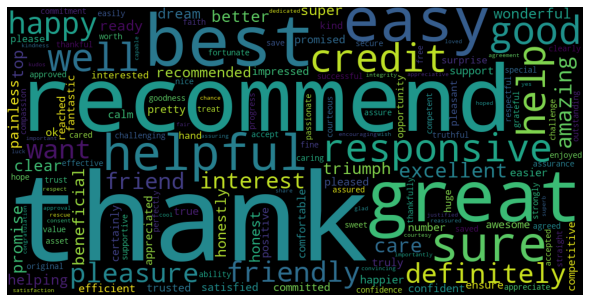

In [39]:
# plotting word cloud for most frequently used positive words
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positive_words_df['Word']))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Key Negative Words

In [40]:
# separating negative words
negative_words_df = count_df[count_df['Sentiment']=='Negative'].sort_values('Count',ascending=False)
negative_words_df

,Word,Count,Sentiment
467,hard,40,Negative
780,problem,34,Negative
761,poor,32,Negative
731,pay,25,Negative
998,stressful,24,Negative
...,...,...,...
603,lost,3,Negative
295,disaster,3,Negative
666,nervous,3,Negative
293,disappeared,3,Negative


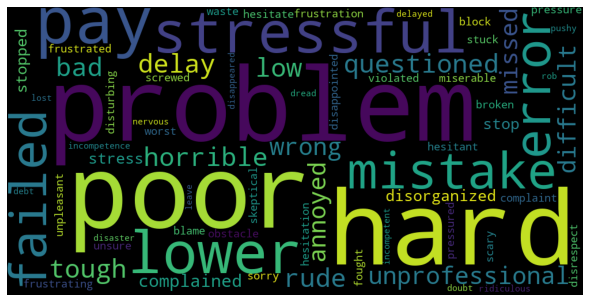

In [41]:
# plotting word cloud for most frequently used negative words
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negative_words_df['Word']))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#3. Classification of reviews into positive, negative and neutral

In [0]:
sentiment_df = reviews_df[reviews_df.columns]

In [0]:
sentiment_df['Sentiment'] = sentiment_df['Reviews'].apply(lambda x: vader_sentiment_value(x))

Positive Reviews

In [47]:
reviews_df_bkp[sentiment_df['Sentiment']=='Positive'].head(10)

,Stars,Reviews
0,5,"Great job, Wyndham Capital! Each person was pr..."
1,5,Matthew Richardson is professional and helpful...
2,5,We had a past experience with Wyndham Mortgage...
3,5,We have been dealing with Brad Thomka from the...
4,5,I can't express how grateful I am for the supp...
5,5,I had the pleasure of working with Wyndham Cap...
6,5,My experience with Mattison was beyond greatly...
7,5,Patrick answered all my questions by email imm...
8,5,I loved working with this group of people! The...
9,5,Great web interface for both the loan applicat...


Negative Reviews

In [48]:
reviews_df_bkp[sentiment_df['Sentiment']=='Negative'].head(10)

,Stars,Reviews
17,1,This was the worst experience ever. It was lik...
36,5,Rob was very helpful in getting this loan clos...
39,1,The closing process for a VA loan went smoothl...
40,1,Miserable experience. They screwed up everythi...
44,1,This Lender contacted my previous phone number...
91,1,\r\nThe team was not aware of some critical in...
93,1,\r\nIf you use Reliance First Capitol...DO NOT...
96,1,\r\nThe experience with Reliance was extremely...
97,1,\r\nPerson with whom I spoke kept interrupting...
100,1,\r\n Lisa Podorson has set my closing date thr...


Neutral Reviews

In [49]:
reviews_df_bkp[sentiment_df['Sentiment']=='Neutral'].head(10)

,Stars,Reviews
41,1,Our loan officer was happy to communicate befo...
45,1,I never write reviews but had to this time to ...
57,5,\r\nVery receptive\r\nThorough\r\nQuick to clo...
92,1,"\r\nIn response to previous review, Greg Belle..."
132,5,\r\nJason straightforward and extremely attent...
217,5,\r\nVery professional and customer oriented.\r...
221,1,\r\nOur loan officer was happy to communicate ...
236,1,\r\nThe rate re-lock-in rule was not followed....
369,5,\r\nGregory understood my needs and he was abl...
390,5,\r\nMike was the best....always there for all...


#4. Identify key themes of problems

### Convert to list

In [50]:
reviews_data = reviews_df['Reviews'].values.tolist()
print(reviews_data[:1])

['great job wyndham capital person professional helped u move refinance process smoothly thank']


### Break Sentences into Words

In [51]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


reviews_data_words = list(sent_to_words(reviews_data))
print(reviews_data_words[:1])

[['great', 'job', 'wyndham', 'capital', 'person', 'professional', 'helped', 'move', 'refinance', 'process', 'smoothly', 'thank']]


In [52]:
# Create Dictionary
id2word = corpora.Dictionary(reviews_data_words)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in reviews_data_words]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [53]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('capital', 1),
  ('great', 1),
  ('helped', 1),
  ('job', 1),
  ('move', 1),
  ('person', 1),
  ('process', 1),
  ('professional', 1),
  ('refinance', 1),
  ('smoothly', 1),
  ('thank', 1),
  ('wyndham', 1)]]

### Building LDA model

#### Finding optimum number of topics using coherence values

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=reviews_data_words
                                                        , start=2, limit=25, step=1)

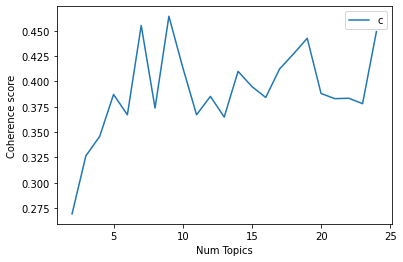

In [56]:
start=2; limit=25; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


#### Build LDA model for number of Topics with best coherence score

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [58]:
# Print the Keyword in the 9 topics
pprint(lda_model.print_topics())

[(0,
  '0.067*"email" + 0.058*"call" + 0.030*"answered" + 0.029*"phone" + '
  '0.026*"find" + 0.024*"decided" + 0.023*"able" + 0.023*"little" + '
  '0.023*"anything" + 0.022*"calling"'),
 (1,
  '0.048*"loan" + 0.029*"time" + 0.028*"officer" + 0.028*"would" + '
  '0.021*"paying" + 0.021*"assessment" + 0.019*"refinance" + 0.018*"company" + '
  '0.017*"new" + 0.017*"money"'),
 (2,
  '0.032*"loan" + 0.029*"rate" + 0.022*"email" + 0.020*"closing" + '
  '0.017*"nasb" + 0.017*"lender" + 0.017*"cost" + 0.016*"read" + 0.014*"total" '
  '+ 0.014*"tax"'),
 (3,
  '0.034*"process" + 0.024*"home" + 0.022*"great" + 0.022*"recommend" + '
  '0.021*"mortgage" + 0.019*"loan" + 0.017*"question" + 0.016*"team" + '
  '0.016*"service" + 0.015*"time"'),
 (4,
  '0.035*"ensure" + 0.034*"expected" + 0.033*"known" + 0.032*"became" + '
  '0.029*"supposed" + 0.029*"knew" + 0.016*"came" + 0.013*"time" + '
  '0.012*"read" + 0.009*"adam"'),
 (5,
  '0.019*"dlj" + 0.015*"responsive" + 0.015*"customer" + 0.015*"kirk" + '

#5. Predicting star ratings using reviews

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X = reviews_bow
Y = reviews_df['Stars']
train_X,test_X,train_Y,test_Y = train_test_split(X,Y,random_state = 123, test_size = 0.3)  

In [61]:
# building naive bayes model
naive_model = MultinomialNB()
naive_model.fit(train_X,train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
predict_train = naive_model.predict(train_X)
predict_test = naive_model.predict(test_X)

In [63]:
print('Accuracy on train: ',metrics.accuracy_score(train_Y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_Y,predict_test))

Accuracy on train:  0.9801699716713881
Accuracy on test:  0.9671052631578947


In [64]:
# confusion matrix on test 
cm_test = metrics.confusion_matrix(test_Y,predict_test,[5,1])
cm_test

array([[119,   2],
       [  3,  28]])

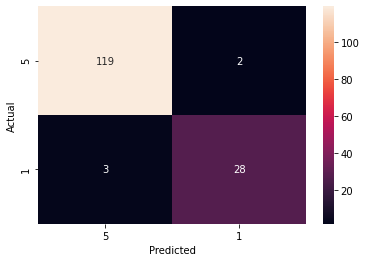

In [65]:
import seaborn as sns
sns.heatmap(cm_test,annot=True,fmt='.3g',xticklabels=[5,1],yticklabels=[5,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [0]:
reviews_df_bkp['Predicted_Stars'] = naive_model.predict(reviews_bow)

In [69]:
reviews_df_bkp[['Reviews', 'Stars', 'Predicted_Stars']]

,Reviews,Stars,Predicted_Stars
0,"Great job, Wyndham Capital! Each person was pr...",5,5
1,Matthew Richardson is professional and helpful...,5,5
2,We had a past experience with Wyndham Mortgage...,5,5
3,We have been dealing with Brad Thomka from the...,5,5
4,I can't express how grateful I am for the supp...,5,5
...,...,...,...
500,\r\nI never write reviews but had to this time...,1,1
501,\r\nIt all started when Bob G ran a credit che...,1,1
502,\r\nWhat a horrible experience. We have excell...,1,1
503,"\r\nRep was extremely professional, friendly, ...",1,1
